In [64]:
%matplotlib inline

from __future__ import division

from collections import namedtuple
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import gamma
from sklearn.cross_validation import permutation_test_score, ShuffleSplit
from sklearn.grid_search import RandomizedSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.metrics import f1_score, make_scorer, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.svm import LinearSVR, LinearSVC

In [44]:
import entrainment_pred

In [25]:
## get best params

result_logs = ['data/step4/%s/search_results.log' % d for d in 
               ['both_hemi', 'left_hemi', 'left_hemi_select_rois'] ]

def view_logged_info(t):
    for log in result_logs:
        parent_dir = os.path.basename(os.path.dirname(log))
        print(parent_dir)
        ! cat $log | grep "$t"
        print("")

In [26]:
view_logged_info("best param")

both_hemi
INFO:atw_z:best params: {'svr__C': 0.098454657585896929}
INFO:atw_diff_wpm:best params: {'svr__C': 0.0062987888851660616}
INFO:adw_z:best params: {'svr__C': 0.060487930870555311}

left_hemi
INFO:atw_z:best params: {'svr__C': 0.098454657585896929}
INFO:adw_z:best params: {'svr__C': 0.0062987888851660616}

left_hemi_select_rois
INFO:atw_z:best params: {'svr__C': 0.0062987888851660616}
INFO:adw_z:best params: {'svr__C': 0.0062987888851660616}



In [172]:
view_logged_info("normalized")

both_hemi
INFO:atw_z:normalized: yes
INFO:atw_diff_wpm:normalized: no
INFO:adw_z:normalized: yes

left_hemi
INFO:atw_z:normalized: yes
INFO:adw_z:normalized: yes

left_hemi_select_rois
INFO:atw_z:normalized: yes
INFO:adw_z:normalized: yes



In [174]:
view_logged_info("best score:")

both_hemi
INFO:atw_z:best score: 0.0841486680109
INFO:atw_diff_wpm:best score: 0.169099889956
INFO:adw_z:best score: 0.0997514050901

left_hemi
INFO:atw_z:best score: -0.0101360274636
INFO:adw_z:best score: 0.0107908601571

left_hemi_select_rois
INFO:atw_z:best score: -0.0118795187186
INFO:adw_z:best score: -0.0258459340886



### Learning Curves Fxns

In [128]:
def create_pipeline(C):
    svr = entrainment_pred.linearSVRPermuteCoefFactory()
    svr.set_params(C=C)
    pipeline_steps = [('svr', svr)]
    return Pipeline(pipeline_steps)

In [61]:
def create_learning_curve(full, target_col, C, col_filter=lambda d: d, normalize=True):
    
    data, target = entrainment_pred.separate(full, target_col)
    
    data = col_filter(data)
    
    data = data.get_values()
    target = target.get_values()
    
    if normalize:
        data = scale(data)
    
    pipeline = create_pipeline(C)
    
    n_iter = 100
    cv = ShuffleSplit(len(target), n_iter=n_iter, test_size=1/6.0, random_state=1234)
    
    train_sizes, train_scores, test_scores = learning_curve(
        pipeline, data, target, cv=cv, train_sizes=np.linspace(.1, 1.0, 5))
    
    return dict(train_sizes=train_sizes, train_scores=train_scores, 
                test_scores=test_scores)

In [39]:
def load_full(t):
    return pd.read_csv("data/step3/full_%s.csv" % t)

full_atw = load_data('atw')
full_adw = load_data('adw')

In [90]:
def left_hemi_filter_gen(f):
    def fn(df):
        jhu_names = entrainment_pred.get_jhu_names(f)
        all_jhu_coordinates = entrainment_pred.all_jhu_coordinates()
        
        def is_valid_conn(conn):
            return np.all([i['name'] in jhu_names for i in 
                           all_jhu_coordinates[conn].itervalues()])
        
        left_cols = filter(is_valid_conn, df.columns)
        return df[left_cols]
    
    return fn

left_hemi_cols = left_hemi_filter_gen("data/jhu_rois_left.csv")
left_hemi_select_cols = left_hemi_filter_gen("data/jhu_rois_left_adjusted.csv")

### Learning Curves Experimentation

In [137]:
def plot_learning_curve(full, target_col, C, 
                        col_filter=lambda d: d, 
                        normalize=True,
                        title=None):
    learning_curve_dict = create_learning_curve(full, target_col, C, 
                                                col_filter=col_filter, 
                                                normalize=normalize)
    if title is None:
        title = target_col.title()
    
    title = title + " %.2e" % C
    
    def disp(score):
        print(score.replace("_", " ").title())
        
        disp_name = score.replace("-", " ")
        train_sizes = learning_curve_dict['train_sizes']
        scores = learning_curve_dict[score]
        
        mn_scores = np.mean(scores, axis=1)
        std_scores = np.std(scores, axis=1)
        
        for info in zip(train_sizes, mn_scores, std_scores):
            print "%s: mean=%.3f, std=%.3f" % info
    
    disp('test_scores')
    disp('train_scores')
    
    entrainment_pred.plot_learning_curve_files(
        title,
        learning_curve_dict["train_scores"],
        learning_curve_dict["test_scores"],
        learning_curve_dict["train_sizes"]
    )

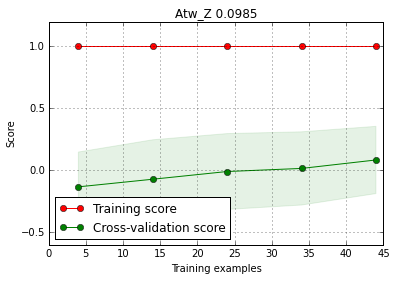

In [94]:
plot_learning_curve(full_atw, 'atw_z', 0.098454657585896929)

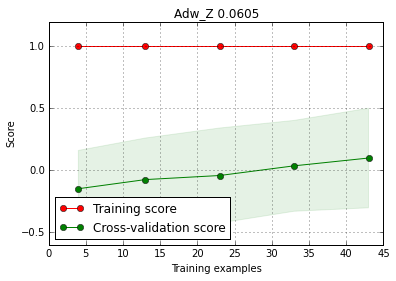

In [95]:
plot_learning_curve(full_adw, 'adw_z', 0.060487930870555311)

## Improve ATW Left Hemi

Test Scores
4: mean=-0.166, std=0.365
14: mean=-0.183, std=0.402
24: mean=-0.142, std=0.399
34: mean=-0.122, std=0.377
44: mean=-0.056, std=0.396
Train Scores
4: mean=1.000, std=0.000
14: mean=1.000, std=0.000
24: mean=1.000, std=0.000
34: mean=1.000, std=0.000
44: mean=1.000, std=0.000


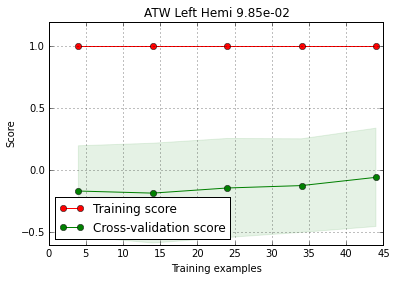

In [140]:
plot_learning_curve(full_atw, 'atw_z', 0.098454657585896929,
                    title="ATW Left Hemi",
                    col_filter=left_hemi_cols
                   )

Test Scores
4: mean=-0.134, std=0.241
14: mean=-0.122, std=0.235
24: mean=-0.111, std=0.234
34: mean=-0.101, std=0.232
44: mean=-0.088, std=0.232
Train Scores
4: mean=-0.530, std=1.218
14: mean=-0.003, std=0.107
24: mean=0.058, std=0.041
34: mean=0.078, std=0.027
44: mean=0.095, std=0.017


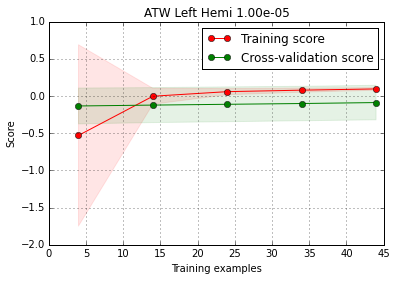

In [147]:
plot_learning_curve(full_atw, 'atw_z', 1e-5,
                    title="ATW Left Hemi",
                    col_filter=left_hemi_cols
                   )

Test Scores
4: mean=-0.108, std=0.255
14: mean=-0.069, std=0.249
24: mean=-0.046, std=0.264
34: mean=-0.040, std=0.291
44: mean=-0.030, std=0.308
Train Scores
4: mean=0.207, std=0.710
14: mean=0.437, std=0.124
24: mean=0.465, std=0.086
34: mean=0.477, std=0.063
44: mean=0.486, std=0.042


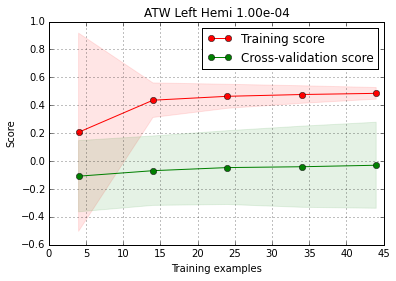

In [148]:
plot_learning_curve(full_atw, 'atw_z', 1e-4,
                    title="ATW Left Hemi",
                    col_filter=left_hemi_cols
                   )

Test Scores
4: mean=-0.166, std=0.365
14: mean=-0.183, std=0.402
24: mean=-0.142, std=0.399
34: mean=-0.122, std=0.377
44: mean=-0.056, std=0.396
Train Scores
4: mean=1.000, std=0.000
14: mean=1.000, std=0.000
24: mean=1.000, std=0.000
34: mean=1.000, std=0.000
44: mean=1.000, std=0.000


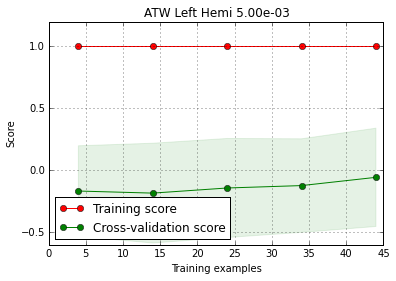

In [159]:
plot_learning_curve(full_atw, 'atw_z', 5e-3,
                    title="ATW Left Hemi",
                    col_filter=left_hemi_cols
                   )

Test Scores
4: mean=-0.122, std=0.307
14: mean=-0.123, std=0.375
24: mean=-0.108, std=0.418
34: mean=-0.111, std=0.430
44: mean=-0.087, std=0.482
Train Scores
4: mean=0.938, std=0.142
14: mean=0.921, std=0.082
24: mean=0.906, std=0.058
34: mean=0.902, std=0.044
44: mean=0.894, std=0.036


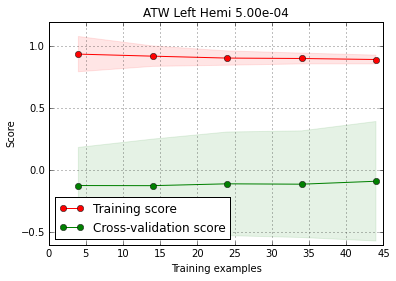

In [153]:
plot_learning_curve(full_atw, 'atw_z', 5e-4,
                    title="ATW Left Hemi",
                    col_filter=left_hemi_cols
                   )

In [156]:
from scipy.optimize import minimize_scalar

In [162]:
def f(full, c, pipeline):
    learning_curve_dict = create_learning_curve(full_atw, 'atw_z', c, 
                                                col_filter=left_hemi_cols)
    return np.mean(learning_curve_dict['test_scores'], axis=1)[-1]

minimize_scalar(f, bounds=(5e-4, 5e-3), method='Bounded', 
                options=dict(disp=50, maxiter=10))

 
 Func-count     x          f(x)          Procedure
    1     0.00221885   -0.0558979        initial
    2     0.00328115   -0.0558939        golden
    3     0.00156231   -0.0503889        golden
    4     0.00274961   -0.0558983        parabolic
    5     0.00252971   -0.0558912        parabolic
    6     0.00295264   -0.0558997        golden
    7     0.00307812   -0.0558868        golden
    8     0.00287509   -0.0558929        golden
    9     0.00300057   -0.0558752        golden
   10     0.00292302   -0.0558999        golden

Maximum number of function evaluations exceeded --- increase maxfun argument.



  status: 1
    nfev: 10
 success: False
     fun: -0.055899851494600757
       x: 0.0029230224602926529
 message: 'Maximum number of function calls reached.'

## Improve ADW Left Hemi

Test Scores
4: mean=-0.170, std=0.364
13: mean=-0.138, std=0.406
23: mean=-0.163, std=0.498
33: mean=-0.071, std=0.398
43: mean=-0.009, std=0.411
Train Scores
4: mean=1.000, std=0.000
13: mean=1.000, std=0.000
23: mean=1.000, std=0.000
33: mean=1.000, std=0.000
43: mean=1.000, std=0.000


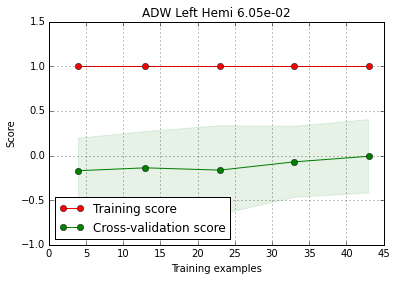

In [163]:
plot_learning_curve(full_adw, 'adw_z', 0.060487930870555311,
                    title="ADW Left Hemi",
                    col_filter=left_hemi_cols
                   )

Test Scores
4: mean=-0.120, std=0.204
13: mean=-0.051, std=0.230
23: mean=-0.027, std=0.256
33: mean=-0.006, std=0.257
43: mean=0.005, std=0.278
Train Scores
4: mean=0.249, std=0.587
13: mean=0.442, std=0.132
23: mean=0.460, std=0.089
33: mean=0.465, std=0.052
43: mean=0.483, std=0.035


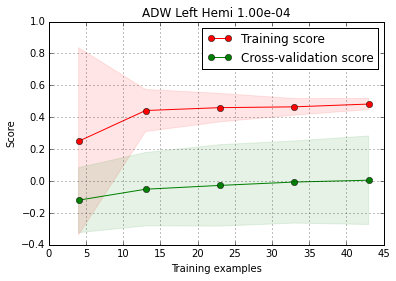

In [164]:
plot_learning_curve(full_adw, 'adw_z', 1e-4,
                    title="ADW Left Hemi",
                    col_filter=left_hemi_cols
                   )

Test Scores
4: mean=-0.155, std=0.190
13: mean=-0.140, std=0.190
23: mean=-0.124, std=0.188
33: mean=-0.113, std=0.190
43: mean=-0.099, std=0.189
Train Scores
4: mean=-0.441, std=0.958
13: mean=0.013, std=0.104
23: mean=0.055, std=0.052
33: mean=0.076, std=0.024
43: mean=0.094, std=0.015


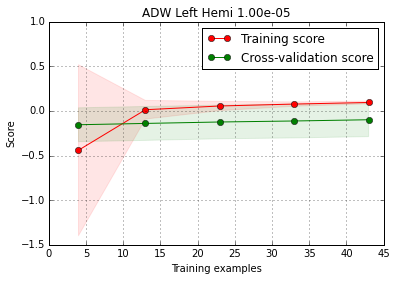

In [165]:
plot_learning_curve(full_adw, 'adw_z', 1e-5,
                    title="ADW Left Hemi",
                    col_filter=left_hemi_cols
                   )

## Improve ADW Left Hemi Select

Test Scores
4: mean=-0.194, std=0.494
13: mean=-0.141, std=0.464
23: mean=-0.186, std=0.576
33: mean=-0.098, std=0.448
43: mean=-0.026, std=0.444
Train Scores
4: mean=0.999, std=0.011
13: mean=0.994, std=0.018
23: mean=0.990, std=0.013
33: mean=0.985, std=0.011
43: mean=0.982, std=0.009


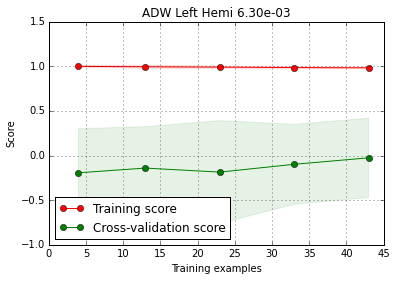

In [175]:
plot_learning_curve(full_adw, 'adw_z', 0.0062987888851660616,
                    title="ADW Left Hemi",
                    col_filter=left_hemi_select_cols
                   )

Test Scores
4: mean=-0.144, std=0.188
13: mean=-0.103, std=0.194
23: mean=-0.064, std=0.195
33: mean=-0.038, std=0.202
43: mean=-0.014, std=0.210
Train Scores
4: mean=-0.291, std=0.882
13: mean=0.112, std=0.112
23: mean=0.163, std=0.069
33: mean=0.188, std=0.040
43: mean=0.214, std=0.027


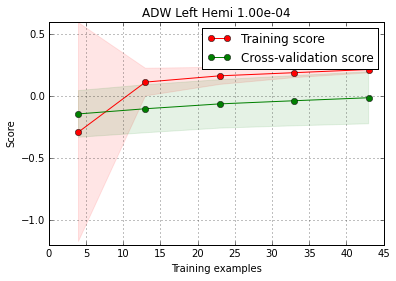

In [178]:
plot_learning_curve(full_adw, 'adw_z', 1e-4,
                    title="ADW Left Hemi",
                    col_filter=left_hemi_select_cols
                   )

Test Scores
4: mean=-0.101, std=0.213
13: mean=-0.018, std=0.249
23: mean=0.011, std=0.273
33: mean=0.039, std=0.274
43: mean=0.050, std=0.289
Train Scores
4: mean=0.313, std=0.539
13: mean=0.478, std=0.146
23: mean=0.495, std=0.099
33: mean=0.497, std=0.058
43: mean=0.515, std=0.040


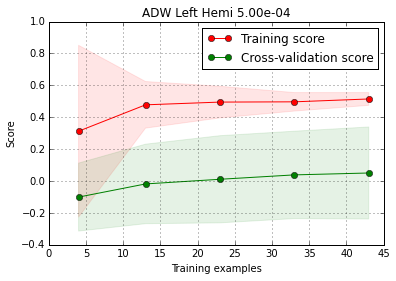

In [179]:
plot_learning_curve(full_adw, 'adw_z', 5e-4,
                    title="ADW Left Hemi",
                    col_filter=left_hemi_select_cols
                   )

Test Scores
4: mean=-0.131, std=0.191
13: mean=-0.067, std=0.207
23: mean=-0.024, std=0.216
33: mean=0.004, std=0.227
43: mean=0.027, std=0.244
Train Scores
4: mean=-0.087, std=0.777
13: mean=0.241, std=0.127
23: mean=0.284, std=0.086
33: mean=0.304, std=0.051
43: mean=0.332, std=0.036


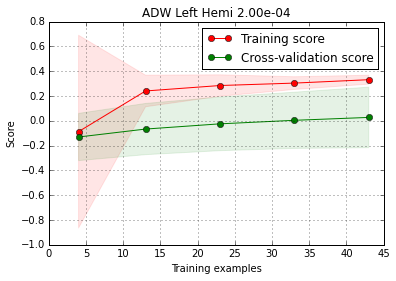

In [180]:
plot_learning_curve(full_adw, 'adw_z', 2e-4,
                    title="ADW Left Hemi",
                    col_filter=left_hemi_select_cols
                   )

Test Scores
4: mean=-0.091, std=0.231
13: mean=-0.009, std=0.271
23: mean=0.006, std=0.314
33: mean=0.030, std=0.301
43: mean=0.031, std=0.317
Train Scores
4: mean=0.486, std=0.416
13: mean=0.577, std=0.146
23: mean=0.584, std=0.101
33: mean=0.578, std=0.060
43: mean=0.593, std=0.041


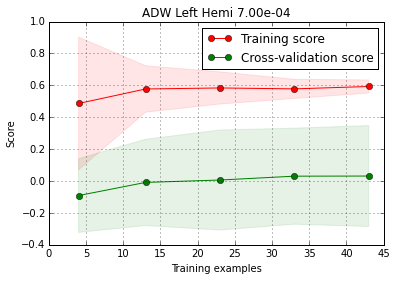

In [181]:
plot_learning_curve(full_adw, 'adw_z', 7e-4,
                    title="ADW Left Hemi",
                    col_filter=left_hemi_select_cols
                   )

## Improve ATW Left Hemi Select

Test Scores
4: mean=-0.189, std=0.528
14: mean=-0.219, std=0.592
24: mean=-0.158, std=0.543
34: mean=-0.120, std=0.485
44: mean=-0.012, std=0.424
Train Scores
4: mean=1.000, std=0.000
14: mean=0.993, std=0.017
24: mean=0.988, std=0.015
34: mean=0.984, std=0.013
44: mean=0.977, std=0.010


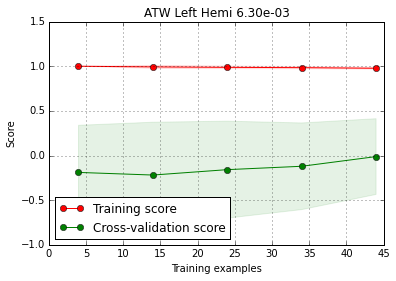

In [182]:
plot_learning_curve(full_atw, 'atw_z', 0.0062987888851660616,
                    title="ATW Left Hemi",
                    col_filter=left_hemi_select_cols
                   )

Test Scores
4: mean=-0.136, std=0.240
14: mean=-0.132, std=0.238
24: mean=-0.127, std=0.237
34: mean=-0.123, std=0.237
44: mean=-0.118, std=0.236
Train Scores
4: mean=-0.633, std=1.281
14: mean=-0.064, std=0.112
24: mean=-0.003, std=0.035
34: mean=0.013, std=0.022
44: mean=0.025, std=0.010


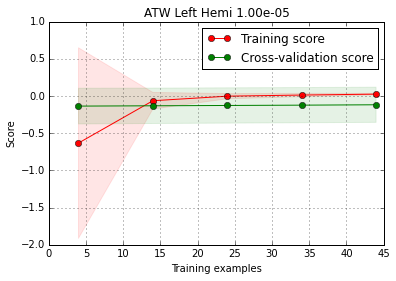

In [186]:
plot_learning_curve(full_atw, 'atw_z', 1e-5,
                    title="ATW Left Hemi",
                    col_filter=left_hemi_select_cols
                   )

Test Scores
4: mean=-0.089, std=0.262
14: mean=-0.044, std=0.275
24: mean=-0.019, std=0.308
34: mean=-0.023, std=0.346
44: mean=-0.008, std=0.338
Train Scores
4: mean=0.260, std=0.691
14: mean=0.475, std=0.142
24: mean=0.504, std=0.099
34: mean=0.513, std=0.073
44: mean=0.518, std=0.049


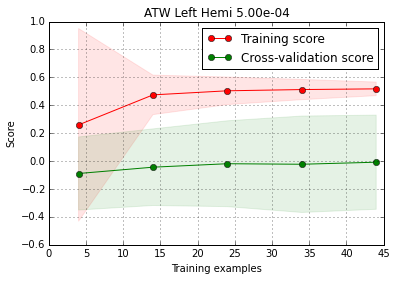

In [184]:
plot_learning_curve(full_atw, 'atw_z', 5e-4,
                    title="ATW Left Hemi",
                    col_filter=left_hemi_select_cols
                   )

Test Scores
4: mean=-0.111, std=0.247
14: mean=-0.066, std=0.233
24: mean=-0.033, std=0.242
34: mean=-0.020, std=0.262
44: mean=-0.000, std=0.270
Train Scores
4: mean=-0.163, std=0.987
14: mean=0.224, std=0.118
24: mean=0.283, std=0.080
34: mean=0.308, std=0.058
44: mean=0.324, std=0.041


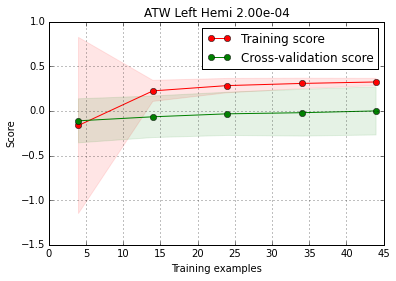

In [185]:
plot_learning_curve(full_atw, 'atw_z', 2e-4,
                    title="ATW Left Hemi",
                    col_filter=left_hemi_select_cols
                   )

Test Scores
4: mean=-0.111, std=0.247
14: mean=-0.066, std=0.233
24: mean=-0.033, std=0.242
34: mean=-0.020, std=0.262
44: mean=-0.000, std=0.270
Train Scores
4: mean=-0.163, std=0.987
14: mean=0.224, std=0.118
24: mean=0.283, std=0.080
34: mean=0.308, std=0.058
44: mean=0.324, std=0.041


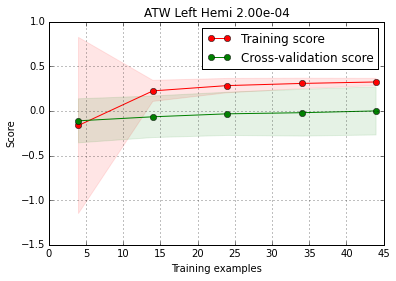

In [189]:
plot_learning_curve(full_atw, 'atw_z', 2e-4,
                    title="ATW Left Hemi",
                    col_filter=left_hemi_select_cols
                   )